# 1. PyTorch Deep Learning Model Lifecycle
## 1-1. Data Preparation
1. `torch.utils.data.Dataset`
2. `torch.utils.data.DataLoader`
   - Batching the data.
   - Shuffling the data.
   - Loading the data in parallel using `multiprocessing` workers.

## 1-2. Model Building
Your model should subclass `torch.nn.Module`. `torch.nn` holds basic build blocks for graphs.
1. `torch.nn.Module.parameters(recurse=True)`: Returns an iterator over module learnable parameters (weights & biases). This is typically passed to an optimizer.
2. `torch.nn.Module.named_parameters(prefix='', recurse=True, remove_duplicate=True)`: Returns an iterator over module parameters, yielding both the name of the parameter as well as the parameter itself.
3. `torch.nn.Module.to(device=None, dtype=None, non_blocking=False)`: Moves and/or casts the parameters and buffers.
4. `torch.nn.Module.load_state_dict(state_dict, strict=True, assign=False)`: Copies parameters and buffers from `state_dict` into this module and its descendants.
5. `torch.nn.Module.state_dict`: A Python dictionary object contains parameters & persistent buffers.

## 1-3. Training
#### Loss Functions:
1. Each PyTorch Loss function creates a criterion that measures the loss between `output` from a model and `target`, returning a `torch.Tensor`.
   - [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
   - Metrics supporting backpropagation (`is_differentiable == True`) in **TorchMetrics** can be used. More details in [Metrics & Differentiability](https://lightning.ai/docs/torchmetrics/stable/pages/overview.html#metrics-and-differentiability).
3. `torch.Tensor.backward(gradient=None, retain_graph=None, create_graph=False, inputs=None)`: Computes the gradient of current tensor with reference to graph leaves. The graph is differentiated using the chain rule. This function accumulates gradients in the leaves.

#### Optimizer:
1. `torch.optim` implements various [Optimization Algorithms](https://pytorch.org/docs/stable/optim.html#algorithms).
2. `torch.optim.Optimizer.step(closure=None)`: Performs a single optimization step (parameter update).
    - For example, [torch.optim.SGD.step(closure=None)](https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63).
3. `torch.optim.Optimizer.zero_grad(set_to_none=True)`: Resets the gradients of all optimized `torch.Tensor`s.
4. `torch.optim.Optimizer.load_state_dict(state_dict)`: Loads the optimizer state. Uses this function when loading a general checkpoint for inference or resuming training.
5. `torch.optim.Optimizer.state_dict`: Contains information about the optimizer's state (parameters to be optimized), as well as the hyperparameters used.
6. `torch.optim.Optimizer.add_param_group(param_group)`: Adds a param group to the `Optimizer`'s `param_groups`. Uses this function when fine tuning a pre-trained network as frozen layers can be made trainable and added to the `Optimizer` as training progresses.

**Gradient Accumulation** refers to the situation, where multiple backwards passes are performed before updating the parameters. The goal is to have the same model parameters for multiple inputs (batches) and then update the model's parameters based on all these batches, instead of performing an update after every single batch. This technique is used to overcome GPU memory limitations when training neural networks.
1. Manual Implementation
2. `pytorch_lightning.Trainer(accumulate_grad_batches)`
3. `accelerate.Accelerator(gradient_accumulation_steps)`

In [10]:
import torch, torch.nn as nn

loss = nn.MSELoss()
# Model output
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.randn(3, 5)
print(target)
output = loss(input, target)
print(output)
output.backward()
print(input.grad)

tensor([[-0.6368,  0.6902, -1.1642,  1.7340,  0.3089],
        [-0.5741, -2.2496,  0.1549,  0.2255, -0.5959],
        [ 0.6467,  0.2575,  1.8013,  0.4424, -0.4409]], requires_grad=True)
tensor([[-0.7584,  0.2138, -0.3933,  0.1054,  0.2149],
        [ 0.2793,  0.7960, -0.1902,  2.1231, -0.5180],
        [ 1.6648, -0.5898,  2.1185,  0.5762,  1.2281]])
tensor(1.4591, grad_fn=<MseLossBackward0>)
tensor([[ 0.0162,  0.0635, -0.1028,  0.2171,  0.0125],
        [-0.1138, -0.4061,  0.0460, -0.2530, -0.0104],
        [-0.1358,  0.1130, -0.0423, -0.0178, -0.2225]])


## 1-4. Evaluation

**Experiment Tracking**

## 1-5. Save & Reload
## 1-6. Inference

# 2. Linear Regression
1. `torch.nn.Linear`
2. `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`

Generate synthetic data with `numpy.random.random(size=None)`.

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

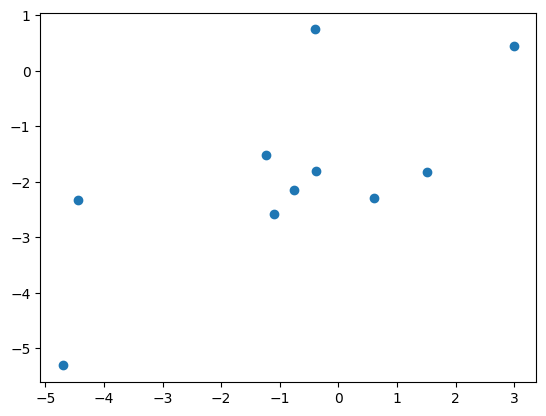

In [9]:
N = 10
# (-5, 5)
X = np.random.random(N) * 10 - 5
y = 0.5 * X - 1 + np.random.randn(N)

plt.scatter(X, y)

In [23]:
model = nn.Linear(1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

X = X.reshape(N, 1)
y = y.reshape(N, 1)

# NumPy creates `float64` by default
inputs = torch.from_numpy(X.astype(np.float32))
targets = torch.from_numpy(y.astype(np.float32))

type(inputs)

torch.Tensor

In [29]:
print(inputs)

tensor([[-0.7517],
        [-1.1045],
        [-1.2412],
        [-0.3923],
        [ 2.9923],
        [ 0.6128],
        [ 1.5206],
        [-4.7027],
        [-0.3810],
        [-4.4450]])


In [30]:
print(targets)

tensor([[-2.1424],
        [-2.5755],
        [-1.5125],
        [ 0.7460],
        [ 0.4411],
        [-2.2813],
        [-1.8139],
        [-5.3069],
        [-1.8115],
        [-2.3218]])


In [24]:
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [25]:
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's `state_dict`:
weight 	 torch.Size([1, 1])
bias 	 torch.Size([1])


In [26]:
optimizer.zero_grad()

print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [27]:
outputs = model(inputs)

print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])
    # print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's `state_dict`:
weight 	 tensor([[0.7652]])
bias 	 tensor([-0.3949])


In [28]:
# input * weight + bias
print(outputs)

tensor([[-0.9701],
        [-1.2401],
        [-1.3446],
        [-0.6951],
        [ 1.8947],
        [ 0.0740],
        [ 0.7686],
        [-3.9934],
        [-0.6865],
        [-3.7962]], grad_fn=<AddmmBackward0>)


In [31]:
# sum((output - target)^2) / 10 = 2.4758
loss = criterion(outputs, targets)
print(loss)

tensor(2.4758, grad_fn=<MseLossBackward0>)


In [32]:
loss.backward()

In [41]:
print(model.weight.grad)
print(model.bias.grad)

tensor([[1.5338]])
tensor([1.7180])


In [42]:
optimizer.step()

In [43]:
# Nothing changes
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [44]:
# 0.7652 - 1.5338 * 0.05 = 0.7652 - 0.07669 = 0.6885
# -0.3949 - 1.7180 * 0.05 = -0.4808
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's `state_dict`:
weight 	 tensor([[0.6885]])
bias 	 tensor([-0.4808])


In [45]:
optimizer.zero_grad()

In [46]:
# Nothing changes
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [47]:
# Nothing changes
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's `state_dict`:
weight 	 tensor([[0.6885]])
bias 	 tensor([-0.4808])


In [48]:
print(model.weight.grad)
print(model.bias.grad)

None
None


In [4]:
n_epochs = 30
losses = []
for it in range(n_epochs):
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f"Epoch {it+1}/{n_epochs}, Loss: {loss.item():.4f}")

Epoch 1/30, Loss: 3.7359
Epoch 2/30, Loss: 3.2713
Epoch 3/30, Loss: 2.9047
Epoch 4/30, Loss: 2.5957
Epoch 5/30, Loss: 2.3300
Epoch 6/30, Loss: 2.1002
Epoch 7/30, Loss: 1.9012
Epoch 8/30, Loss: 1.7288
Epoch 9/30, Loss: 1.5794
Epoch 10/30, Loss: 1.4499
Epoch 11/30, Loss: 1.3377
Epoch 12/30, Loss: 1.2405
Epoch 13/30, Loss: 1.1563
Epoch 14/30, Loss: 1.0833
Epoch 15/30, Loss: 1.0200
Epoch 16/30, Loss: 0.9652
Epoch 17/30, Loss: 0.9177
Epoch 18/30, Loss: 0.8765
Epoch 19/30, Loss: 0.8408
Epoch 20/30, Loss: 0.8099
Epoch 21/30, Loss: 0.7831
Epoch 22/30, Loss: 0.7599
Epoch 23/30, Loss: 0.7398
Epoch 24/30, Loss: 0.7223
Epoch 25/30, Loss: 0.7072
Epoch 26/30, Loss: 0.6941
Epoch 27/30, Loss: 0.6828
Epoch 28/30, Loss: 0.6730
Epoch 29/30, Loss: 0.6644
Epoch 30/30, Loss: 0.6571


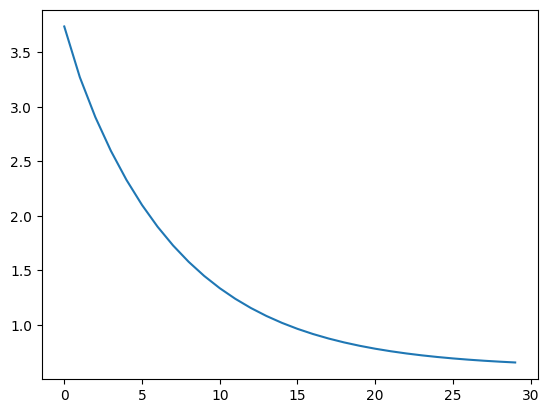

In [5]:
plt.plot(losses)

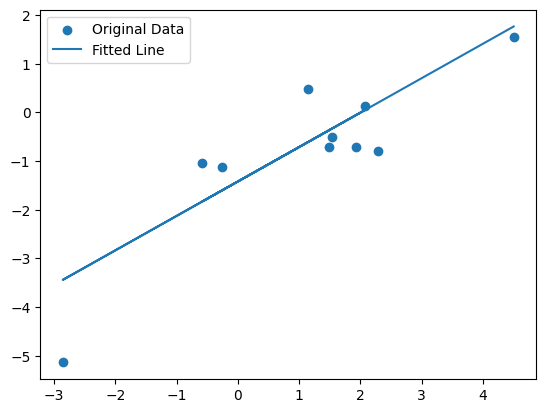

In [6]:
predictions = model(inputs).detach().numpy()
plt.scatter(X, y, label="Original Data")
plt.plot(X, predictions, label="Fitted Line")
plt.legend()
plt.show()

In [7]:
w = model.weight.data.numpy()
b = model.bias.data.numpy()
# (0.5, -1)
print(w, b)

[[0.70741653]] [-1.4193791]


# 3. Logistic Regression

- **Binary Logistic Regression**, or **Binomial Logistic Regression** models the relationship between a set of independent variables and a binary dependent variable. For example, "true" or "false", "positive" or "negative".
- **Multiclass logistic regression**, **Multinomial Logistic Regression** or **Softmax Regression** is an extension of logistic regression for multiclass classification. For example, "red", "green", "blue".
    - The **One vs Rest (OVR)** or **One vs All** strategy splits a multiclass classification into one binary classification problem per class. For example, "red" or "green/blue", "green" or "blue/red", "blue" or "red, green". Softmax regression calculates the probabilities for each class and normalizes them using the softmax function, ensuring they sum up to one.
    - The **One vs One (OvO)** strategy splits a multiclass classification into one binary classification problem per each pair of classes.

**Binary Cross Entropy** for **Binary Classification**:
1. `torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')`
2. `torch.nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)`: Combines a `Sigmoid` layer and the `BCELoss` in one single class.

**Cross Entropy Loss** for **Multiclass Classification**: 
1. `torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean', label_smoothing=0.0)`: Computes the cross entropy loss between input logits and target.

[Diagnostic Wisconsin Breast Cancer Database](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)
- `sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)`

In [177]:
from sklearn.datasets import load_breast_cancer

In [178]:
data = load_breast_cancer()
type(data)

sklearn.utils._bunch.Bunch

In [179]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [180]:
data.data.shape

(569, 30)

In [181]:
data.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [182]:
data.target.shape

(569,)

In [183]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [184]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
N, D = X_train.shape
N, D

(381, 30)

In [186]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [133]:
model = nn.Sequential(
    nn.Linear(D,1), 
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [187]:
y_train.shape

(381,)

In [188]:
y_train.astype(np.float32).reshape(-1, 1).shape

(381, 1)

In [189]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))

In [137]:
n_epochs = 1000

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    outputs_test = model(X_test)
    loss_test = criterion(outputs_test, y_test)

    train_losses[it] = loss.item()
    test_losses[it] = loss_test.item()

    if (it + 1) % 50 == 0:
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}")

Epoch 50/1000, Train Loss: 0.5543, Test Loss: 0.5545
Epoch 100/1000, Train Loss: 0.4093, Test Loss: 0.4079
Epoch 150/1000, Train Loss: 0.3302, Test Loss: 0.3276
Epoch 200/1000, Train Loss: 0.2800, Test Loss: 0.2766
Epoch 250/1000, Train Loss: 0.2450, Test Loss: 0.2411
Epoch 300/1000, Train Loss: 0.2191, Test Loss: 0.2149
Epoch 350/1000, Train Loss: 0.1993, Test Loss: 0.1947
Epoch 400/1000, Train Loss: 0.1836, Test Loss: 0.1788
Epoch 450/1000, Train Loss: 0.1709, Test Loss: 0.1658
Epoch 500/1000, Train Loss: 0.1604, Test Loss: 0.1552
Epoch 550/1000, Train Loss: 0.1516, Test Loss: 0.1462
Epoch 600/1000, Train Loss: 0.1441, Test Loss: 0.1386
Epoch 650/1000, Train Loss: 0.1376, Test Loss: 0.1321
Epoch 700/1000, Train Loss: 0.1319, Test Loss: 0.1264
Epoch 750/1000, Train Loss: 0.1269, Test Loss: 0.1215
Epoch 800/1000, Train Loss: 0.1224, Test Loss: 0.1170
Epoch 850/1000, Train Loss: 0.1185, Test Loss: 0.1131
Epoch 900/1000, Train Loss: 0.1149, Test Loss: 0.1096
Epoch 950/1000, Train Loss: 0

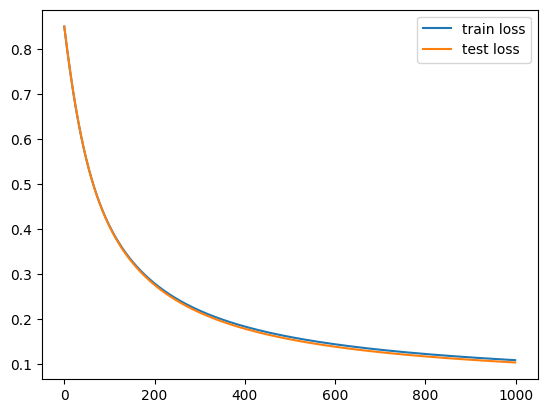

In [138]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [139]:
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    train_acc = np.mean(y_train.numpy() == p_train)

    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_acc = np.mean(y_test.numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9738, Test acc: 0.9734


In [190]:
# `BCEWithLogitsLoss()`
model_2 = nn.Linear(D,1)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_2.parameters())

In [196]:
print(model_2)

Linear(in_features=30, out_features=1, bias=True)


In [191]:
n_epochs = 1000

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
train_acc = np.zeros(n_epochs)
test_acc = np.zeros(n_epochs)

for it in range(n_epochs):
    optimizer.zero_grad()

    outputs = model_2(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    outputs_test = model_2(X_test)
    loss_test = criterion(outputs_test, y_test)

    train_losses[it] = loss.item()
    test_losses[it] = loss_test.item()

    if (it + 1) % 50 == 0:
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}")

Epoch 50/1000, Train Loss: 0.5003, Test Loss: 0.4939
Epoch 100/1000, Train Loss: 0.3675, Test Loss: 0.3612
Epoch 150/1000, Train Loss: 0.2979, Test Loss: 0.2907
Epoch 200/1000, Train Loss: 0.2547, Test Loss: 0.2462
Epoch 250/1000, Train Loss: 0.2250, Test Loss: 0.2151
Epoch 300/1000, Train Loss: 0.2032, Test Loss: 0.1920
Epoch 350/1000, Train Loss: 0.1865, Test Loss: 0.1741
Epoch 400/1000, Train Loss: 0.1732, Test Loss: 0.1597
Epoch 450/1000, Train Loss: 0.1625, Test Loss: 0.1480
Epoch 500/1000, Train Loss: 0.1536, Test Loss: 0.1383
Epoch 550/1000, Train Loss: 0.1461, Test Loss: 0.1301
Epoch 600/1000, Train Loss: 0.1397, Test Loss: 0.1231
Epoch 650/1000, Train Loss: 0.1342, Test Loss: 0.1171
Epoch 700/1000, Train Loss: 0.1293, Test Loss: 0.1118
Epoch 750/1000, Train Loss: 0.1250, Test Loss: 0.1072
Epoch 800/1000, Train Loss: 0.1212, Test Loss: 0.1031
Epoch 850/1000, Train Loss: 0.1177, Test Loss: 0.0995
Epoch 900/1000, Train Loss: 0.1146, Test Loss: 0.0962
Epoch 950/1000, Train Loss: 0

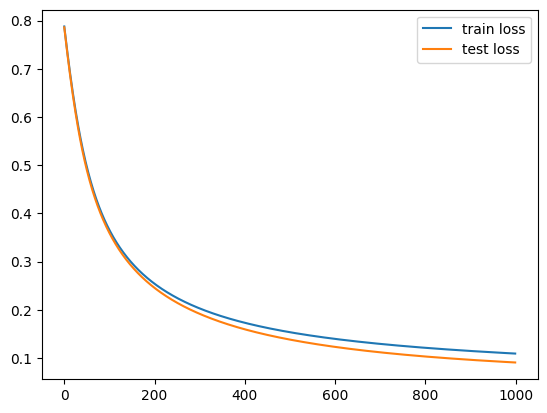

In [192]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [194]:
with torch.no_grad():
    p_train = model_2(X_train)
    p_train = (p_train.numpy() > 0)
    train_acc = np.mean(y_train.numpy() == p_train)

    p_test = model_2(X_test)
    p_test = p_test.numpy() > 0
    test_acc = np.mean(y_test.numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9738, Test acc: 0.9840


# 4. Artificial Neural Network (ANN)
- **Single Layer Artificial Neural Network**, or **Single Layer Neural Network** is the simplest form of an artificial neural network, often referred to as a "perceptron".
    - A **Perceptron**, **Single Layer Perceptron**, or **McCulloch–Pitts Neuron**, is an algorithm for supervised learning a binary classifier called threshold function. In the context of neural networks, a perceptron is an artificial neuron using the Heaviside step function as the activation function. The perceptron was intended to be a machine, rather than a program, and the first hardware implementation is **Mark I Perceptron** by Frank Rosenblatt.
    - [Perceptron](https://en.wikipedia.org/wiki/Perceptron#Learning_algorithm_for_a_single-layer_perceptron)
    - If you have a single layer neural network with logistic activation function, and assuming you maximize the log-likelihood (or minimize the cross entropy), then you are performing logistic regression.
    - [Logistic Regression as a Single Layer Perceptron](https://en.wikipedia.org/wiki/Logistic_regression#As_a_single-layer_perceptron)

- **Single Hidden-Layer Neural Network**

Demonstrate **Non-Linearity** with`sklearn.datasets.make_circles(n_samples=100, *, shuffle=True, noise=None, random_state=None, factor=0.8)`.

In [150]:
from sklearn.datasets import make_circles

# blob data
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=100)
len(X), len(y)

(1000, 1000)

In [151]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[-1.00038985  0.02348052]
 [-0.19036705 -1.01750748]
 [ 0.71463597  0.37954286]
 [ 0.60316858 -0.78886949]
 [ 0.56238969  0.56515025]]
First 5 samples of y:
 [0 0 1 0 1]


In [152]:
import pandas as pd

# Make DataFrame of circle data
circles = pd.DataFrame({
    "X_1": X[:, 0],
    "X_2": X[:, 1],
    "label": y
})
circles.head(10)

,X_1,X_2,label
0,-1.000390,0.023481,0
1,-0.190367,-1.017507,0
2,0.714636,0.379543,1
3,0.603169,-0.788869,0
4,0.562390,0.565150,1
5,0.025748,1.006406,0
6,1.050432,-0.097989,0
7,0.623187,0.525558,1
8,0.747905,-0.180497,1
9,0.559672,-0.620578,1


In [153]:
circles.label.value_counts()

label
0    500
1    500
Name: count, dtype: int64

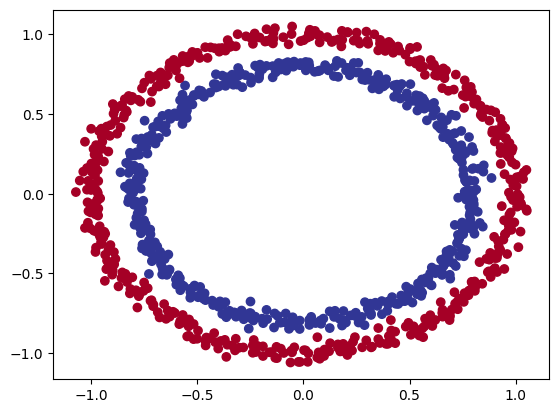

In [154]:
import matplotlib.pyplot as plt

# Visualize
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [155]:
X.shape, y.shape

((1000, 2), (1000,))

In [156]:
# View the first sample of features & labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [-1.00038985  0.02348052] and the same for y: 0
Shapes for one sample of X: (2,) and the same for y: ()


In [157]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [158]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-1.0004,  0.0235],
         [-0.1904, -1.0175],
         [ 0.7146,  0.3795],
         [ 0.6032, -0.7889],
         [ 0.5624,  0.5652]]),
 tensor([0., 0., 1., 0., 1.]))

In [159]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [160]:
from sklearn.model_selection import train_test_split

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=36)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [161]:
X_train.shape

torch.Size([800, 2])

In [14]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [163]:
# [1] Construct a model that subclasses `nn.module`
class LinearSingleHiddenLayerNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # [2] Create 2 `nn.Linear` layers capable of handling the shapes of our data
    self.hidden = nn.Linear(in_features=2, out_features=10)
    self.output = nn.Linear(in_features=10, out_features=1)

  # [3] Define a `forward()` method that outlines the forward pass
  def forward(self, x):
    return self.output(self.hidden(x))

# Replicate the model using `nn.Sequential()`
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# [4] Instantiate an instance of the model class and send it to the target device
linear_model = LinearSingleHiddenLayerNeuralNetwork().to(device)
linear_model

LinearSingleHiddenLayerNeuralNetwork(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [164]:
# Setup the loss function
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

# Setup the optimizer
optimizer = torch.optim.SGD(params=linear_model.parameters(), lr=0.1)

In [165]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [166]:
torch.manual_seed(100)
torch.cuda.manual_seed(100)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training & evaluation loop
for epoch in range(epochs):
  # Training
  linear_model.train()

  # [1] Forward pass
  y_logits = linear_model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # [2] Calculate loss/acc
  # `nn.BCELoss` expects prediction probabilities as input
  # loss = loss_fn(torch.sigmoid(y_logits), y_train)
  # `nn.BCEWithLogitsLoss` expects raw logits as input
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # [3] Optimizer zero grad
  optimizer.zero_grad()

  # [4] Loss backward (backpropagation)
  loss.backward()

  # [5] Optimizer step (gradient descent)
  optimizer.step()

  # Testing
  linear_model.eval()
  with torch.inference_mode():
    # [1] Forward pass
    test_logits = linear_model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # [2] Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc}%")

Epoch: 0 | Loss: 0.69975, Acc: 50.75% | Test loss: 0.69323, Test acc: 51.5%
Epoch: 10 | Loss: 0.69696, Acc: 51.12% | Test loss: 0.69298, Test acc: 53.5%
Epoch: 20 | Loss: 0.69529, Acc: 50.75% | Test loss: 0.69319, Test acc: 54.50000000000001%
Epoch: 30 | Loss: 0.69428, Acc: 51.38% | Test loss: 0.69361, Test acc: 55.50000000000001%
Epoch: 40 | Loss: 0.69367, Acc: 51.75% | Test loss: 0.69409, Test acc: 54.0%
Epoch: 50 | Loss: 0.69330, Acc: 54.00% | Test loss: 0.69455, Test acc: 53.0%
Epoch: 60 | Loss: 0.69308, Acc: 55.75% | Test loss: 0.69497, Test acc: 52.5%
Epoch: 70 | Loss: 0.69294, Acc: 56.12% | Test loss: 0.69533, Test acc: 50.0%
Epoch: 80 | Loss: 0.69286, Acc: 55.50% | Test loss: 0.69563, Test acc: 48.5%
Epoch: 90 | Loss: 0.69280, Acc: 53.87% | Test loss: 0.69588, Test acc: 47.0%


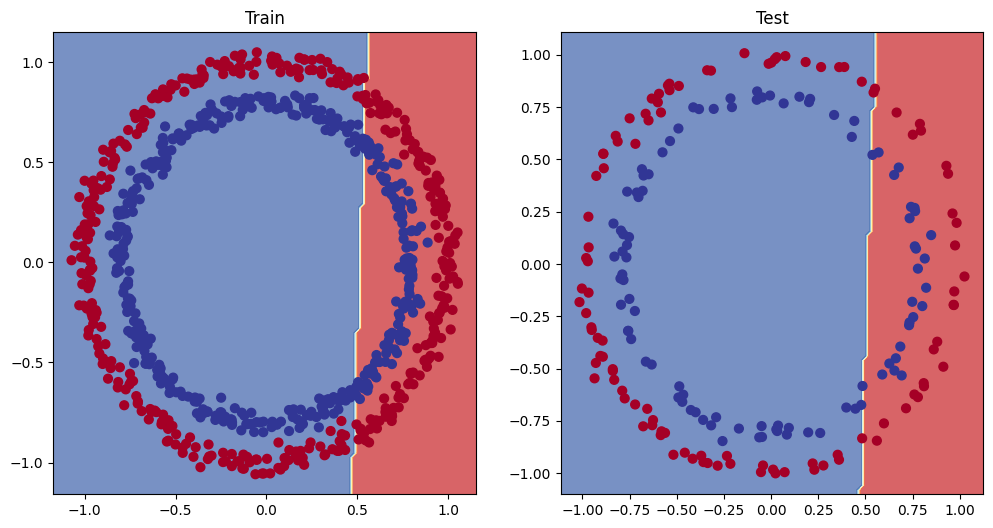

In [167]:
# Plot decision boundaries of model predicting on X in comparison to y
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
  # Put everything to CPU for working better with NumPy & Matplotlib
  model.to("cpu")
  X, y = X.to("cpu"), y.to("cpu")

  # Setup prediction boundaries & grid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  # Make predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  # Test for multi-class or binary and adjust logits to prediction labels
  if len(torch.unique(y)) > 2:
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
  else:
    y_pred = torch.round(torch.sigmoid(y_logits))  # binary

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(linear_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(linear_model, X_test, y_test)

In [168]:
class NonlinearSingleHiddenLayerNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()
    # relu is a non-linear activation function
    
  def forward(self, x):
    return self.layer_2(self.relu(self.layer_1(x)))

nonlinear_model = NonlinearSingleHiddenLayerNeuralNetwork().to(device)
nonlinear_model

NonlinearSingleHiddenLayerNeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [169]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# Write a training and evaluation loop for model_1
torch.manual_seed(100)
torch.cuda.manual_seed(100)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  nonlinear_model.train()
  # [1] Forward pass
  y_logits = nonlinear_model(X_train).squeeze()
  # Raw logits to prediction probabilities to prediction labels
  y_pred = torch.round(torch.sigmoid(y_logits))

  # [2] Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # [3] Optimizer zero grad
  optimizer.zero_grad()

  # [4] Loss backward (backpropagation)
  loss.backward()

  # [5] Optimizer step (gradient descent)
  optimizer.step()

  # Testing
  nonlinear_model.eval()
  with torch.inference_mode():
    # [1] Forward pass
    test_logits = nonlinear_model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # [2] Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc}%")

Epoch: 0 | Loss: 0.69838, Acc: 48.62% | Test loss: 0.68964, Test acc: 52.5%
Epoch: 100 | Loss: 0.68619, Acc: 62.50% | Test loss: 0.68570, Test acc: 61.0%
Epoch: 200 | Loss: 0.68017, Acc: 61.88% | Test loss: 0.68166, Test acc: 65.0%
Epoch: 300 | Loss: 0.67444, Acc: 62.88% | Test loss: 0.67679, Test acc: 65.0%
Epoch: 400 | Loss: 0.66742, Acc: 66.75% | Test loss: 0.67034, Test acc: 66.5%
Epoch: 500 | Loss: 0.65866, Acc: 72.25% | Test loss: 0.66235, Test acc: 71.0%
Epoch: 600 | Loss: 0.64813, Acc: 77.88% | Test loss: 0.65298, Test acc: 79.5%
Epoch: 700 | Loss: 0.63504, Acc: 81.38% | Test loss: 0.64180, Test acc: 83.5%
Epoch: 800 | Loss: 0.61958, Acc: 86.12% | Test loss: 0.62814, Test acc: 87.5%
Epoch: 900 | Loss: 0.60134, Acc: 90.38% | Test loss: 0.61210, Test acc: 88.5%


In [170]:
# Makes predictions
nonlinear_model.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(nonlinear_model(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0'))

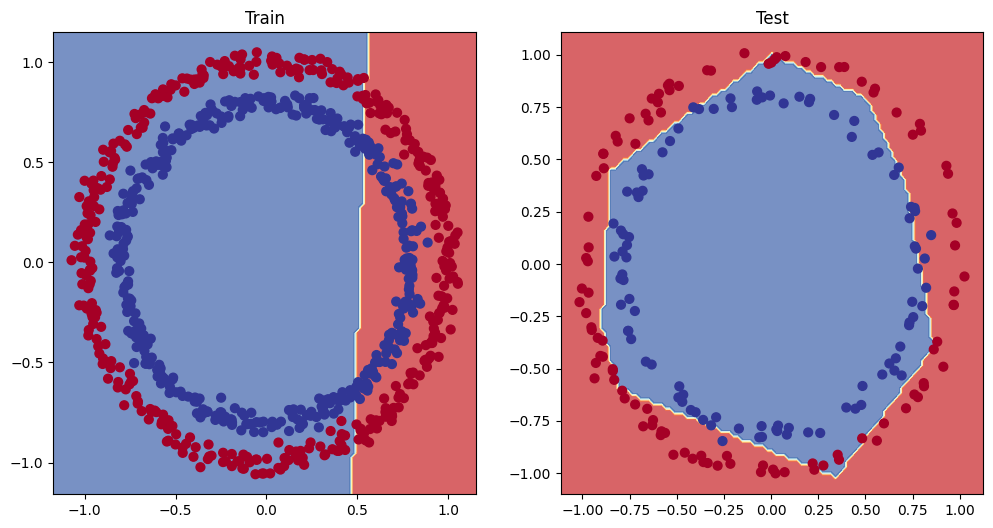

In [171]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
# `model_1` has no non-linearity
plot_decision_boundary(linear_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
# `model_2` has non-linearity
plot_decision_boundary(nonlinear_model, X_test, y_test)

# 5. Deep Neural Networks (DNNs)
A fully connected multi-layer feedforward neural network with a nonlinear activation function is called a **Multilayer Perceptron (MLP)**. A MLP consists of three or more layers (an input and an output layer with one or more hidden layers).
- MLP is a misnomer.
- An input layer is not a layer; it's just input data. Hidden layers are the layers that processing happens.
    - `tensorflow.keras.Input(shape=None, batch_size=None, dtype=None, sparse=None, batch_shape=None, name=None, tensor=None)` only serves as a specification of the kind of input the model expects, including the dimensions and type of data, does not hold any data itself.
    - There is no equivalent for PyTorch. To instantiate the input layer, you can create an uninitialized tensor using `torch.empty` or, instead, use `torch.zeros` to initialize it with zeros like TensorFlow's default.
 
Generate isotropic Gaussian blobs using `sklearn.datasets.make_blobs(n_samples=100, n_features=2, *, centers=None, cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=None, return_centers=False)` to demonstrate multiclass classification.

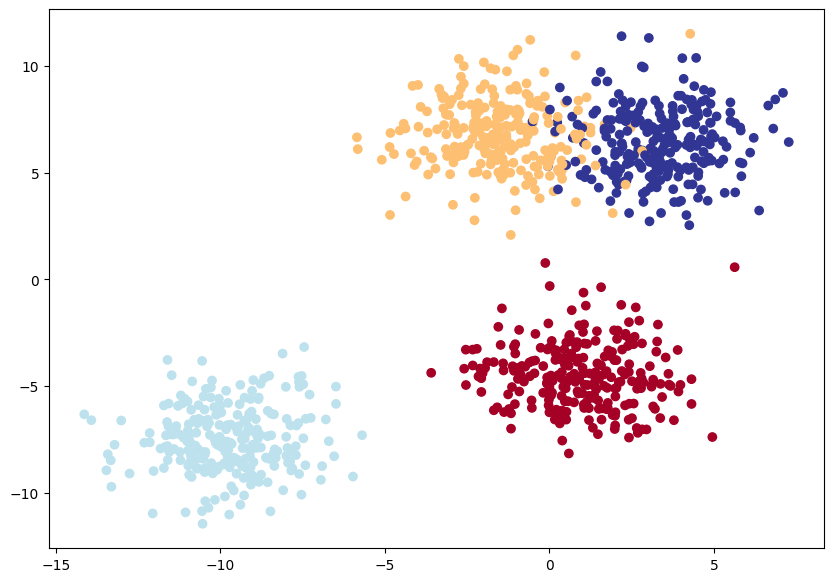

In [172]:
from sklearn.datasets import make_blobs

# Multi-class
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 100

# [1] Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# [2] Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# [3] Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# [4] Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [173]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_3 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [174]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 3, 3, 0, 2]))

In [175]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [176]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

# Get some raw outputs of the model (logits)
model_2.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.4492, -0.4329, -1.1219,  0.0512],
        [ 1.5299,  2.0159, -0.1637,  1.9851],
        [-0.0509,  1.9585,  1.6363, -0.7892],
        [-0.7101,  0.6771,  0.6877, -1.1317],
        [-0.4827, -0.4282, -1.0757, -0.0115],
        [-0.3630,  1.4567,  1.3288, -1.0193],
        [-0.5467, -0.5626, -1.1814, -0.0382],
        [ 1.3230,  2.0274,  0.0976,  1.6096],
        [ 0.0113,  1.9458,  1.5452, -0.6705],
        [-0.5504, -0.1839, -0.6653, -0.2902]], device='cuda:0')

In [177]:
y_blob_test[:10]

tensor([0, 2, 1, 3, 0, 1, 0, 2, 1, 0])

In [178]:
# Convert the model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:10])

tensor([[0.2395, 0.2434, 0.1222, 0.3950],
        [0.2280, 0.3707, 0.0419, 0.3594],
        [0.0697, 0.5201, 0.3768, 0.0333],
        [0.1030, 0.4125, 0.4169, 0.0676],
        [0.2375, 0.2508, 0.1312, 0.3805],
        [0.0762, 0.4703, 0.4139, 0.0395],
        [0.2394, 0.2356, 0.1269, 0.3981],
        [0.2151, 0.4352, 0.0632, 0.2865],
        [0.0766, 0.5298, 0.3549, 0.0387],
        [0.2159, 0.3115, 0.1925, 0.2801]], device='cuda:0')


In [179]:
# Convert the model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 1, 1, 2, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1,
        3, 3, 2, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        2, 3, 2, 1, 2, 3, 3, 3, 3, 3, 1, 2, 2, 3, 3, 3, 1, 3, 3, 1, 2, 2, 3, 3,
        1, 3, 2, 3, 1, 3, 2, 1, 1, 1, 1, 3, 2, 3, 2, 1, 3, 1, 3, 2, 1, 2, 3, 3,
        3, 3, 1, 2, 3, 2, 1, 3, 1, 3, 3, 2, 3, 1, 1, 2, 3, 3, 2, 3, 3, 1, 3, 3,
        1, 3, 3, 2, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 2, 1, 3, 2, 1,
        3, 1, 1, 3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 1, 2, 1, 2, 3, 1, 1, 3, 1, 3, 3,
        2, 3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3,
        1, 3, 3, 3, 1, 2, 1, 3], device='cuda:0')

In [180]:
y_blob_test

tensor([0, 2, 1, 3, 0, 1, 0, 2, 1, 0, 2, 2, 1, 1, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0,
        0, 2, 3, 0, 0, 2, 1, 2, 3, 0, 1, 1, 2, 0, 0, 1, 3, 1, 2, 3, 1, 2, 1, 3,
        3, 2, 3, 1, 3, 0, 2, 0, 2, 0, 1, 3, 3, 0, 0, 0, 1, 2, 2, 1, 3, 3, 0, 2,
        1, 0, 3, 0, 1, 2, 3, 1, 0, 1, 3, 2, 3, 0, 3, 2, 0, 1, 0, 3, 1, 3, 2, 0,
        0, 2, 1, 3, 2, 3, 3, 2, 1, 2, 2, 3, 2, 1, 3, 3, 0, 2, 3, 0, 0, 2, 2, 2,
        0, 0, 0, 3, 1, 2, 3, 0, 1, 3, 3, 1, 1, 0, 2, 2, 0, 1, 1, 3, 1, 0, 3, 1,
        2, 1, 3, 2, 0, 2, 3, 0, 1, 2, 2, 1, 2, 0, 3, 1, 3, 0, 1, 2, 2, 1, 2, 2,
        3, 2, 0, 1, 2, 2, 1, 2, 0, 0, 1, 3, 0, 2, 0, 0, 3, 1, 2, 0, 0, 1, 2, 0,
        1, 0, 0, 2, 1, 3, 3, 2])

In [181]:
# Fit the multi-class model to the data
torch.manual_seed(100)
torch.cuda.manual_seed(100)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  # Training
  model_3.train()

  y_logits = model_3(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.0815, Acc: 24.12% | Test loss: 1.0658, Test acc: 51.50%
Epoch: 10 | Loss: 0.2692, Acc: 95.38% | Test loss: 0.2692, Test acc: 93.50%
Epoch: 20 | Loss: 0.1526, Acc: 96.38% | Test loss: 0.1733, Test acc: 94.00%
Epoch: 30 | Loss: 0.1234, Acc: 96.38% | Test loss: 0.1466, Test acc: 94.50%
Epoch: 40 | Loss: 0.1114, Acc: 96.25% | Test loss: 0.1348, Test acc: 95.00%
Epoch: 50 | Loss: 0.1051, Acc: 96.25% | Test loss: 0.1280, Test acc: 95.00%
Epoch: 60 | Loss: 0.1013, Acc: 96.38% | Test loss: 0.1234, Test acc: 95.00%
Epoch: 70 | Loss: 0.0988, Acc: 96.38% | Test loss: 0.1200, Test acc: 95.00%
Epoch: 80 | Loss: 0.0970, Acc: 96.38% | Test loss: 0.1173, Test acc: 95.00%
Epoch: 90 | Loss: 0.0957, Acc: 96.38% | Test loss: 0.1150, Test acc: 95.00%


In [182]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  5.7410,  -7.2668,  -3.7514,  -3.4430],
        [  0.4629,   6.8166,  14.1665, -14.0343],
        [-11.1185,  14.2302,   4.5972,   7.2861],
        [ -5.4848,   4.9606,  -2.5346,   7.6589],
        [  5.4460,  -7.0513,  -3.9396,  -2.9505],
        [ -9.3235,  10.8719,   1.4825,   8.1727],
        [  6.0764,  -8.0499,  -4.6571,  -2.9822],
        [ -1.2117,   7.9745,  12.9615, -11.1143],
        [-10.5385,  13.7914,   4.9358,   6.3465],
        [  2.8970,  -4.3086,  -3.7336,  -0.3656]], device='cuda:0')

In [183]:
# Go from logits to Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[9.9982e-01, 2.2422e-06, 7.5409e-05, 1.0265e-04],
        [1.1177e-06, 6.4223e-04, 9.9936e-01, 5.6527e-13],
        [9.7893e-12, 9.9897e-01, 6.5461e-05, 9.6331e-04],
        [1.8342e-06, 6.3071e-02, 3.5052e-05, 9.3689e-01],
        [9.9969e-01, 3.7354e-06, 8.3895e-05, 2.2558e-04],
        [1.5883e-09, 9.3691e-01, 7.8325e-05, 6.3012e-02],
        [9.9986e-01, 7.3278e-07, 2.1800e-05, 1.1637e-04],
        [6.9450e-07, 6.7795e-03, 9.9322e-01, 3.4758e-11],
        [2.7124e-11, 9.9927e-01, 1.4248e-04, 5.8403e-04],
        [9.6121e-01, 7.1362e-04, 1.2683e-03, 3.6805e-02]], device='cuda:0')

In [184]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([0, 2, 1, 3, 0, 1, 0, 2, 1, 0], device='cuda:0')

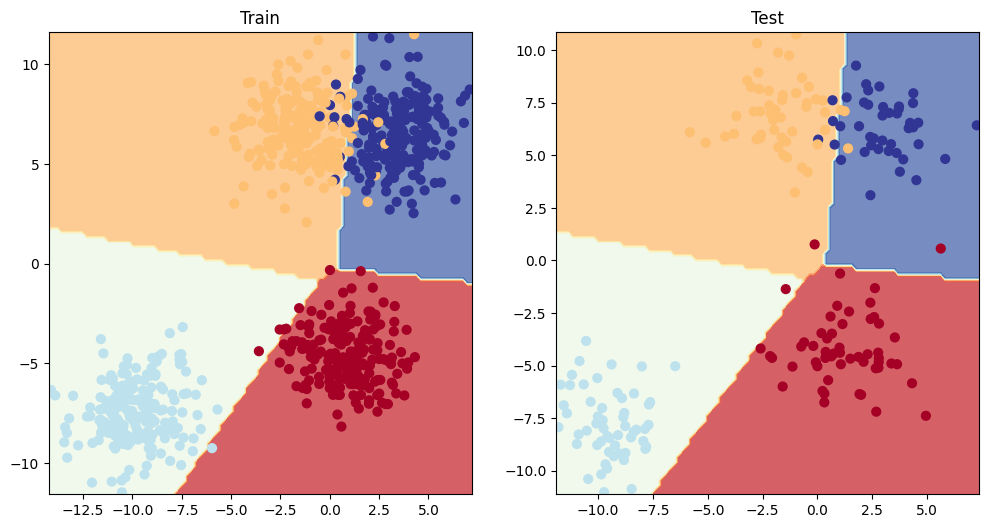

In [185]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)

# 11. Convolutional Neural Networks (CNNs)
## 11-1. Image Classification with LeNet-5

In [1]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

In [2]:
import torchvision

train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True)
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(train_dataset.data.min(), train_dataset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(train_dataset.data.float().mean(), train_dataset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(train_dataset.data.float().mean() / 255, train_dataset.data.float().std() / 255))

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.31842041015625 
Pixel Values Std: 78.56748962402344
Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624


In [3]:
test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True)
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(test_dataset.data.min(), test_dataset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(test_dataset.data.float().mean(), test_dataset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(test_dataset.data.float().mean() / 255, test_dataset.data.float().std() / 255))

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.791221618652344 
Pixel Values Std: 79.17247009277344
Scaled Mean Pixel Value 0.1325145959854126 
Scaled Pixel Values Std: 0.3104802668094635


In [5]:
import torch

#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize((32,32)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize((32,32)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [10]:
import torch.nn as nn

# Define the model
class LeNet5(nn.Module):
    def __init__(self, K):
        super(LeNet5, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        # "No zero padding, non-unit strides"
        # https://pytorch.org/docs/stable/nn.html
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, K)
        )
  
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

model = LeNet5(num_classes).to(device)
model

LeNet5(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=120, out_features=84, bias=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [11]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

total_step = len(train_loader)
total_step

938

In [14]:
# Loop through data
for epoch in range(num_epochs):
  # Training
  for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = loss_fn(outputs, labels)

      # Backward & optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i + 1) % 400 == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/10], Step [400/938], Loss: 0.0209
Epoch [1/10], Step [800/938], Loss: 0.0154
Epoch [2/10], Step [400/938], Loss: 0.0931
Epoch [2/10], Step [800/938], Loss: 0.0954
Epoch [3/10], Step [400/938], Loss: 0.0467
Epoch [3/10], Step [800/938], Loss: 0.1767
Epoch [4/10], Step [400/938], Loss: 0.0360
Epoch [4/10], Step [800/938], Loss: 0.0144
Epoch [5/10], Step [400/938], Loss: 0.1090
Epoch [5/10], Step [800/938], Loss: 0.0107
Epoch [6/10], Step [400/938], Loss: 0.0227
Epoch [6/10], Step [800/938], Loss: 0.0312
Epoch [7/10], Step [400/938], Loss: 0.0247
Epoch [7/10], Step [800/938], Loss: 0.0248
Epoch [8/10], Step [400/938], Loss: 0.0003
Epoch [8/10], Step [800/938], Loss: 0.0679
Epoch [9/10], Step [400/938], Loss: 0.0147
Epoch [9/10], Step [800/938], Loss: 0.0694
Epoch [10/10], Step [400/938], Loss: 0.0181
Epoch [10/10], Step [800/938], Loss: 0.0727


In [15]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 98.56 %


# 12. Recurrent Neural Networks (RNNs)
[Large Movie Review Dataset](https://ai.stanford.edu/%7Eamaas/data/sentiment/) for binary sentiment classification from Stanford.
- [imdb_reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews)

In [1]:
import pandas as pd
import glob

# Get the class names from the target directory
class_names_found = ['pos', 'neg']

# Construct a pandas DataFrame using `read()`
dict_train = []

for class_name in class_names_found:
    doc_lst = glob.glob(f"./datasets/aclImdb_v1/aclImdb/train/{class_name}/*.txt", recursive=True)
    for filename in doc_lst:
        with open(filename, 'r', errors='replace') as f:
            # Use `read()` instead of `readlines()`
            doc = f.read()
            dict_train.append({"text": doc, "label": class_name})

df_train = pd.DataFrame(dict_train)
df_train

,text,label
0,I don't understand why the other comments focu...,pos
1,The information contained in this movie is som...,pos
2,The premise of this anime series is about brea...,pos
3,"I watched the first series avidly, but wondere...",pos
4,"""GOOD TIMES,"" in my opinion, is a must-see CBS...",pos
...,...,...
24995,"First of all, I was expecting ""Caged Heat"" to ...",neg
24996,THIS IS NOT A CHILDREN'S MOVIE!!!<br /><br />T...,neg
24997,"Perhaps because I was so young, innocent and B...",neg
24998,By all the fawning people have been doing over...,neg


In [2]:
# Construct a pandas DataFrame using `read()`
dict_test = []

for class_name in class_names_found:
    doc_lst = glob.glob(f"./datasets/aclImdb_v1/aclImdb/test/{class_name}/*.txt", recursive=True)
    for filename in doc_lst:
        with open(filename, 'r', errors='replace') as f:
            # Use `read()` instead of `readlines()`
            doc = f.read()
            dict_test.append({"text": doc, "label": class_name})

df_test = pd.DataFrame(dict_test)
df_test

,text,label
0,I like both this version of DORIAN GRAY and th...,pos
1,"On the face of it, any teen comedy runs the ri...",pos
2,"""Icky Flix"" is an excellent starting point for...",pos
3,"I just saw this at SIFF, and I absolutely love...",pos
4,"The creative team of Jim Abrahams, David Zucke...",pos
...,...,...
24995,I am sitting here writing this review and the ...,neg
24996,I can't believe some of the scores this film i...,neg
24997,"I have just watched this ""latest"" version of M...",neg
24998,"Woa, talk about awful. Do not waste your time....",neg


In [3]:
df_train['label'] = df_train['label'].map({'neg': 0, 'pos': 1})
df_train

,text,label
0,I don't understand why the other comments focu...,1
1,The information contained in this movie is som...,1
2,The premise of this anime series is about brea...,1
3,"I watched the first series avidly, but wondere...",1
4,"""GOOD TIMES,"" in my opinion, is a must-see CBS...",1
...,...,...
24995,"First of all, I was expecting ""Caged Heat"" to ...",0
24996,THIS IS NOT A CHILDREN'S MOVIE!!!<br /><br />T...,0
24997,"Perhaps because I was so young, innocent and B...",0
24998,By all the fawning people have been doing over...,0


In [4]:
df_test['label'] = df_test['label'].map({'neg': 0, 'pos': 1})
df_test

,text,label
0,I like both this version of DORIAN GRAY and th...,1
1,"On the face of it, any teen comedy runs the ri...",1
2,"""Icky Flix"" is an excellent starting point for...",1
3,"I just saw this at SIFF, and I absolutely love...",1
4,"The creative team of Jim Abrahams, David Zucke...",1
...,...,...
24995,I am sitting here writing this review and the ...,0
24996,I can't believe some of the scores this film i...,0
24997,"I have just watched this ""latest"" version of M...",0
24998,"Woa, talk about awful. Do not waste your time....",0


## 7-1. Masking & Padding

**Masking** is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data. **Padding** is a special form of masking where the masked steps are at the start or the end of a sequence. Padding comes from the need to encode sequence data into contiguous batches. In order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences. The steps are as follows:

- Truncate and pad samples to a uniform length, for Individual samples of sequence data usually have different lengths.
- Mask some parts of the input data which are actually paddings and should be ignored, before sending inputs to the model.
- Pad the model outputs.

If you still want to use `Dataset` & `DataLoader` provided by PyTorch, you can choose either padding before sending data into `Dataset` or customizing `collate_fn` in `DataLoader`.

PyTorch:

1. `torch.nn.utils.rnn.pad_sequence(sequences, batch_first=False, padding_value=0.0)`: Stacks a list of `Tensor`s along a new dimension and pads them to equal length. For example, if the input is a list of sequences with size `(L, *)` and `batch_first` is False, the output is of size `(B, T, *)`. `B` is batch size. It is equal to the number of elements in sequences. `T` is length of the longest sequence. `L` is length of the sequence. `*` is any number of trailing dimensions, including `None`. Only supports post padding.
   - Because of **Gradient Vanishing**, pre padding is recommended.
   - [Effects of Padding on LSTMs & CNNs](https://arxiv.org/abs/1903.07288)
2. `torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)`: Packs a `Tensor` containing padded sequences of variable length. All RNN modules in PyTorch accept packed sequences as inputs.
3. `torch.nn.utils.rnn.pad_packed_sequence(sequence, batch_first=False, padding_value=0.0, total_length=None)`: Pads a packed batch of variable length sequences.
4. `torch.nn.utils.rnn.pack_sequence(sequences, enforce_sorted=True)`: Consecutive call of `pad_sequence` & `pack_padded_sequence`.

Keras:

5. `tf.keras.utils.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)`: Supports truncating and pre padding.
   - [Masking](https://www.tensorflow.org/guide/keras/understanding_masking_and_padding#masking) in TensorFlow

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
sequences_train = tokenizer.texts_to_sequences(df_train.text)
# filtered_sequence_train = list(filter(lambda x: (x != []), sequence_train))
sequences_test = tokenizer.texts_to_sequences(df_test.text)

# Get sequence lengths
train_lengths = [len(x) for x in sequences_train]
test_lengths = [len(x) for x in sequences_test]

word2idx = tokenizer.word_index
V = len(word2idx)
print("Found %s unique tokens." % V)

2024-07-21 23:27:15.166471: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 23:27:15.174508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 23:27:15.184825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 23:27:15.184840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 23:27:15.192033: I tensorflow/core/platform/cpu_feature_gua

Found 88582 unique tokens.


In [258]:
# `pad_sequences()` from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print("Shape of Training Set Tensor:", data_train.shape)
print("Sample:", data_train[0])

Shape of Training Set Tensor: (25000, 2493)
Sample: [  0   0   0 ...  73 326 218]


In [259]:
# `pad_sequence()`
from torch.nn.utils.rnn import pad_sequence

# Convert list of lists to list of tensors
sequences_train_tensor = list(map(lambda x: torch.as_tensor(x), sequences_train))
data_train = pad_sequence(sequences=sequences_train_tensor, batch_first=True)
print("Shape of Training Set Tensor:", data_train.shape)
print("Sample:", data_train[0])

Shape of Training Set Tensor: torch.Size([25000, 2493])
Sample: tensor([ 10,  89, 388,  ...,   0,   0,   0])


In [261]:
# `pack_padded_sequence()`
from torch.nn.utils.rnn import pack_padded_sequence

train_lengths_tensor = torch.as_tensor(train_lengths)
packed_data_train = pack_padded_sequence(input=data_train, lengths=train_lengths_tensor, batch_first=True, enforce_sorted=False)
packed_data_train

PackedSequence(data=tensor([1012, 2737,  688,  ...,    3,    7,    7]), batch_sizes=tensor([25000, 25000, 25000,  ...,     1,     1,     1]), sorted_indices=tensor([ 5079,   329,  7842,  ..., 22795, 24523, 13597]), unsorted_indices=tensor([16274,  9240, 19451,  ..., 15842,  6124,  2493]))

In [262]:
# `pad_packed_sequence()`
from torch.nn.utils.rnn import pad_packed_sequence

unpacked_data_train, unpacked_train_lengths = pad_packed_sequence(sequence=packed_data_train, batch_first=True)
print("Shape of Training Set Tensor:", unpacked_data_train.shape)
print("Sample:", unpacked_data_train[0])

Shape of Training Set Tensor: torch.Size([25000, 2493])
Sample: tensor([ 10,  89, 388,  ...,   0,   0,   0])


In [265]:
# `pack_sequence()`
sequences_train_tensor = list(map(lambda x: torch.as_tensor(x), sequences_train))
packed_data_train = pack_sequence(sequences=sequences_train_tensor, enforce_sorted=False)
packed_data_train

PackedSequence(data=tensor([1012, 2737,  688,  ...,    3,    7,    7]), batch_sizes=tensor([25000, 25000, 25000,  ...,     1,     1,     1]), sorted_indices=tensor([ 5079,   329,  7842,  ..., 22795, 24523, 13597]), unsorted_indices=tensor([16274,  9240, 19451,  ..., 15842,  6124,  2493]))

In [136]:
# Custom pre padding for PyTorch
from torch import Tensor
from typing import Union, List

def pad_sequence_with_pos(
    sequences: Union[Tensor, List[Tensor]],
    batch_first: bool = False,
    padding_value: float = 0.0,
    pos: str = 'post',
) -> Tensor:

    if pos == 'post':
        padded_sequence = torch._C._nn.pad_sequence(sequences, batch_first, padding_value)
    elif pos == 'pre':
        sequences = tuple(map(lambda s: s.flip(0), sequences))
        padded_sequence = torch._C._nn.pad_sequence(sequences, batch_first, padding_value)
        _seq_dim = padded_sequence.dim()
        padded_sequence = padded_sequence.flip(-_seq_dim+batch_first)
    else:
        raise ValueError("pos should be either 'post' or 'pre', but got {}".format(pos))
    return padded_sequence

In [137]:
sequences_train_tensor = list(map(lambda x: torch.as_tensor(x), sequences_train))
data_train = pad_sequence_with_pos(sequences_train_tensor, batch_first=True, pos='pre')
print("Shape of Training Set Tensor:", data_train.shape)

Shape of Training Set Tensor: torch.Size([25000, 2493])


Handle sequence padding & packing.

In [6]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Pad test set & turn label series to tensors
y_train = torch.tensor(df_train['label'].values)
y_test = torch.tensor(df_test['label'].values)

sequences_train_tensor = list(map(lambda x: torch.as_tensor(x), sequences_train))
data_train = pad_sequence(sequences_train_tensor, batch_first=True)
# sequences_train_tensor = torch.cat(sequences_train_tensor)
sequences_test_tensor = list(map(lambda x: torch.as_tensor(x), sequences_test))
data_test = pad_sequence(sequences_test_tensor, batch_first=True)

In [7]:
sequence_lengths_train = torch.tensor([len(seq) for seq in sequences_train])
sequence_lengths_test = torch.tensor([len(seq) for seq in sequences_test])
print(sequence_lengths_train)
print(sequence_lengths_test)

tensor([144, 222, 125,  ..., 148, 293, 466])
tensor([125, 630, 130,  ...,  81, 117, 464])


In [18]:
# `TensorDataset()`
train_dataset = torch.utils.data.TensorDataset(data_train, y_train)
test_dataset = torch.utils.data.TensorDataset(data_test, y_test)
train_dataset[0]

(tensor([ 10,  89, 388,  ...,   0,   0,   0]), tensor(1))

In [37]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.y = y
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return (self.data[idx], self.y[idx])

train_dataset = CustomDataset(sequences_train_tensor, y_train)
train_dataset[0]

(tensor([   10,    89,   388,   135,     1,    82,   792,  1148,    20, 14896,
            26,    44,   112,    74,     3,    52,   218,    19,   281,     7,
             7,     1,   115,   170,     4,    11,    17,     6,     1,   484,
             2,     1,  2205,  4939, 13886,     2,  2326, 40830,    94,    32,
          1727,   695,  3866,   404,    21,  2043,  2103,   258,    28,   188,
           132,    65,   102,    23,    70,  1383,    12,   149,    94,    95,
            98,   326,   160,     7,     7,     1,   307,    10,   216,    13,
            20, 40831,     2,    66,  2567,    15,     1,  1866,   804,    35,
            12,    13,   431,    21,     3,   436,     1,   358,     4,  1866,
           405,     9,    50,  6259,     7,     7,     3,    52,  2178,    17,
          4201,    31,     1,  6985,   361,   600,   894,  1063,    25,   345,
             9,    10,   194,     9,    13,   250,     2,   218,     2,   287,
             3,   690,    30,   219,     3,   173,  

In [23]:
# train_dataset = CustomDataset(data_train, y_train)
# train_dataset[0]

(tensor([ 10,  89, 388,  ...,   0,   0,   0]), tensor(1))

In [59]:
test_dataset = CustomDataset(sequences_test_tensor, y_test)
test_dataset[0]

(tensor([   10,    37,   196,    11,   307,     4, 31688,  3833,     2,     1,
          2727,   307,   196,   758,     3,   114,   247,   399,     8,     1,
            62,    34,  3414,    53,     5,    25,    32,  8951,    16, 31688,
            11,     6,    21,     8,     1,   201,   271,     2,    12,     6,
            58,    61,  3290,    10,   259,    37,  4934,  9042,    14, 10303,
         37673,     2,   739,  7073,    14,  1331,     8,     1,  2727,   307,
            18, 11839, 59093,    14, 31688,     8,     1,   245,   307,     6,
            73,   125,   264,    10,   101,     2,   227,    50,  4269,    71,
         68102, 68103,     8,     1,  2727,   307,    10,   101, 59093,     6,
            50,   280,     5,     1, 14727, 31688,     8,     1,   127,    11,
             6,     3,    52,    49,  1251,     4,     1,   664,     9,    57,
          4190,    30,    16,   346,    14,   124,    60,    97,    21,    27,
           221,     8,     1,  2727,   307]),
 tenso

In [60]:
from torch.utils.data import Dataset, DataLoader

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    # print(xx, yy)

    x_lens = [len(x) for x in xx]
    y_lens = 1

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = torch.Tensor(yy)

    return xx_pad, yy_pad, x_lens, y_lens

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

In [61]:
# Iterate through the dataloader to display text and label
train_features, train_y, train_length, train_y_length = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(train_y)
print(f"Feature batch shape: {train_y.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
text = train_features[0].squeeze()
y = train_y[0].squeeze()
length = train_length[0]
y_len = train_y_length
print(f"Text: {text}")
print(f"y: {y}")
print(f"Length: {length}")
print(f"y Length: {y_len}")

Feature batch shape: torch.Size([32, 586])
tensor([1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.])
Feature batch shape: torch.Size([32])
Text: tensor([    8,     3, 23587,   685,  4720, 14618,     3,  2759, 14753, 26880,
        24776,    34,   340,    24,  1167,     5,  3520,     3,  7816,     2,
           13,  7866,    31,    24,   319,     1,  2384, 19538, 11667, 26881,
            2,    24, 31908,     1,  3002, 20114, 14856, 24778,    34, 10034,
           24,  1443,  1924,   796,     2,     1,  2769,  8912, 16069, 24777,
           34,   554,    24,   319,    28,   311, 14753,   655,    32,  2210,
        14296,  1596,     8,     3,  2941,     8,     1,  1510,     4,     1,
         2759,    33,   920,    12,     1,   271,    13,   395,    31, 30618,
         8479,  6047,     8,     1,   451,     4,     1,   233,  1116,     2,
            6,    41,   325,  1233,    33,  1194,     5,   329,   

## 7-2. RNN

In [13]:
"""
from gensim.models import Word2Vec

model = Word2Vec(sequences_train, vector_size=128, window=3, min_count=3, workers=4)
word_vectors = model.wv
embedding_weights = torch.Tensor(word_vectors.vectors)
embedding_weights
"""

tensor([[-1.0129,  0.0183,  0.7175,  ...,  0.7672, -0.9444,  0.2395],
        [-1.3071, -0.1407,  1.4345,  ...,  0.0131,  0.0352, -0.9314],
        [-1.0343, -1.4306, -1.7839,  ...,  2.1762, -0.7733,  1.6307],
        ...,
        [ 0.0199, -0.0128,  0.0347,  ...,  0.0035,  0.0036,  0.0352],
        [ 0.0544, -0.0275,  0.0026,  ..., -0.0211, -0.0036, -0.0074],
        [ 0.0345,  0.0060,  0.0284,  ..., -0.0060, -0.0078, -0.0048]])

In [62]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [69]:
import torch.nn as nn

# Define the model
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X, X_lengths):
        h_0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c_0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        out = self.embed(X)
        print(out.shape)
        # (2493, 128) # (25000, 2493)
        out = torch.nn.utils.rnn.pack_padded_sequence(out, X_lengths, batch_first=True, enforce_sorted=False)
        out, _ = self.rnn(out, (h_0, c_0))
        out, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(out)
        out, _ = torch.max(out, 1)
        out = self.fc(out)
        return out

In [70]:
model = RNN(V+1, 128, 256, 1, 1)
model.to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [58]:
from datetime import datetime
import numpy as np

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t_0 = datetime.now()
        train_loss = []
        for inputs, targets, x_lens, y_lens in train_loader:
            # print("inputs.shape:", inputs.shape, "targets.shape", targets.shape)
            targets = targets.view(-1, 1).float()
            # Move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, x_lens)
            loss = criterion(outputs, targets)

            # Backward & optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss & test loss
        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets, x_lens, y_lens in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(inputs, x_lens)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t_0
        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
    return train_losses, test_losses

train_losses, test_losses = batch_gd(model, criterion, optimizer, train_dataloader,  15)

NameError: name 'test_dataloader' is not defined

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

## 7-3. GRU

## 7-4. LSTM

## 5-1. Model Improvement
- [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)